In [1]:
import torch
import pickle
import numpy as np
import pandas as pd
from nnet import CNNbiLSTM

$\textbf{Epidemiology: Clinical Model Results Aggregation}$

$\textbf{Model \& Data Loading}$

Organize model results into a table:

- __Epochs Trained__ (prior to stopping)
- __Validation Scores__ (loss, accuracy)

In [2]:
import torch.nn.functional as F

In [3]:
# load model w/ path 
def load_model(
        model_skeleton: any,
        model_path: str
        ) -> CNNbiLSTM:
    """
    Loads a CNNbiLSTM model from a specified path.
    
    Args:
        model_skeleton (any): An instance of the nnet model class to load.
        model_path (str): Path to the model file.
        
    Returns:
        CNNbiLSTM: Loaded model instance.
    """
    # load the model state dictionary
    state_dict = torch.load(model_path)
    model_skeleton.load_state_dict(state_dict)
    
    # set the model to evaluation mode
    model_skeleton.eval()

    return model_skeleton


In [4]:
# instatiate model
model_path = f'models/inj/pitch_model_state_dict.pt'
model_app = load_model(CNNbiLSTM(k_in=7), model_path)

# load validation data
    # --> tensor dictionary
with open(f'models/data/pitch_model_val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)

In [ ]:
# pass validation data through model to get predictions
with torch.no_grad():
    # run model, compute loss
    _, logits, _ = model_app(
        val_data['x'].float(), 
        val_data['lengths'].float(),
        val_data['mask'].bool()
    )
    val_loss = F.binary_cross_entropy_with_logits(
        logits, 
        val_data['y_binary'], 
        pos_weight=torch.tensor(3.3262)
    ).item()

    # output statement
    print(f'Validation Loss: {val_loss:.3f}')
    
    # convert logits to probabilities
    val_probs = torch.sigmoid(logits).detach().cpu().numpy()
    val_preds = (val_probs >= 0.5).astype(int)

Validation Loss: 0.878


In [379]:
logits.shape

torch.Size([463])

$\textit{Performance Summary}$

Tables 2 and 3.

In [130]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

In [131]:
# raw accuracy
raw_acc = (val_preds == val_data['y_binary'].numpy()).mean()
print(f'Validation Accuracy: {raw_acc:.3f}')

# confusion matrix
cm = confusion_matrix(val_data['y_binary'].numpy(), val_preds)
cm_df = pd.DataFrame(cm, index=['Actual Neg', 'Actual Pos'], columns=['Pred Neg', 'Pred Pos'])

# display confusion matrix
print("\nConfusion Matrix:")
print(cm_df)

# compute F1 score, precision, recall   
f1 = f1_score(val_data['y_binary'].numpy(), val_preds, average='weighted')
precision = precision_score(val_data['y_binary'].numpy(), val_preds, average='weighted')
recall = recall_score(val_data['y_binary'].numpy(), val_preds, average='weighted')
print(f'\nF1 Score: {f1:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')

# compute AUC
auc = roc_auc_score(val_data['y_binary'].numpy(), val_probs, average='weighted')
print(f'AUC: {auc:.3f}')

Validation Accuracy: 0.715

Confusion Matrix:
            Pred Neg  Pred Pos
Actual Neg       278        92
Actual Pos        40        53

F1 Score: 0.735 | Precision: 0.772 | Recall: 0.715
AUC: 0.713


$\textbf{Training History}$

Figure 4.

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
# load results by epoch
with open(f'storage/pitch_model_results.pkl', 'rb') as f:
    pitch_model_results = pickle.load(f)

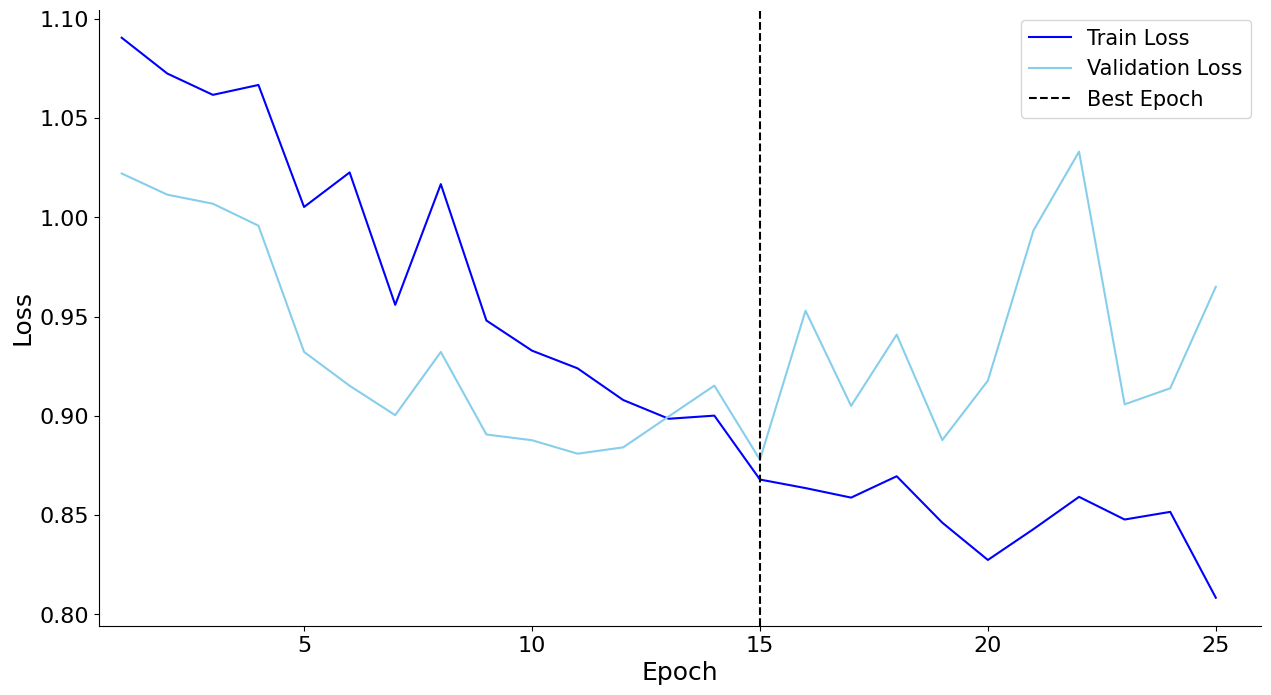

In [428]:
# organize loss values into DataFrame
loss_df = pd.DataFrame([pitch_model_results['train_loss'], pitch_model_results['val_loss']]).T
loss_df.columns = ['Train Loss', 'Validation Loss']
loss_df.index += 1
loss_df.index.name = 'Epoch'

# plot loss values
plt.figure(figsize=(15, 8))
plt.plot(loss_df.index, loss_df['Train Loss'], label='Train Loss', color='blue')
plt.plot(loss_df.index, loss_df['Validation Loss'], label='Validation Loss', color='skyblue')

# add vertical line at epoch of best validation loss
best_epoch = np.argmin(loss_df['Validation Loss']) + 1
plt.axvline(x=best_epoch, color='black', linestyle='--', label='Best Epoch')

# labels
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)

# tick sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# xlimit
plt.xlim(0.5, len(loss_df) + 1)

# add legend, make larger
plt.legend(fontsize=15)

# hide upper and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

$\textbf{Per-Pitch Model Estimated Injury Probability Comparison}$

In [186]:
import torch

In [458]:
# set up per-pitch probability storage
pitch_level_probs = {
    'injured': {
        'probs': [],
        'attn': None
    },
    'noninjured': {
        'probs': [],
        'attn': None
    }
}

In [459]:
# iterate through positive tensor, get model probabilities at each timestep --> injured pitcher
IDX = -6
with torch.no_grad():
    seq, logit, attn = model_app(
        val_data['x'][IDX].unsqueeze(0).float()[:, 0:71], 
        torch.Tensor([val_data['x'][IDX][val_data['mask'][IDX]][0:71].shape[0]]),
        val_data['mask'][IDX].unsqueeze(0).bool()[:, 0:71]
    )

    # add to dictionary
    pitch_level_probs['injured']['probs'] = seq
    pitch_level_probs['injured']['attn'] = attn.squeeze(0).squeeze(0).cpu().numpy()

In [ ]:
# repeat for non-injured pitcher
IDX = 1
with torch.no_grad():
    seq, logit, attn = model_app(
        val_data['x'][IDX].unsqueeze(0).float()[:, 0:71], 
        torch.Tensor([val_data['x'][IDX][val_data['mask'][IDX]][0:71].shape[0]]),
        val_data['mask'][IDX].unsqueeze(0).bool()[:, 0:71]
    )

    # add to dictionary
    pitch_level_probs['noninjured']['probs'] = seq
    pitch_level_probs['noninjured']['attn'] = attn.squeeze(0).squeeze(0).cpu().numpy()

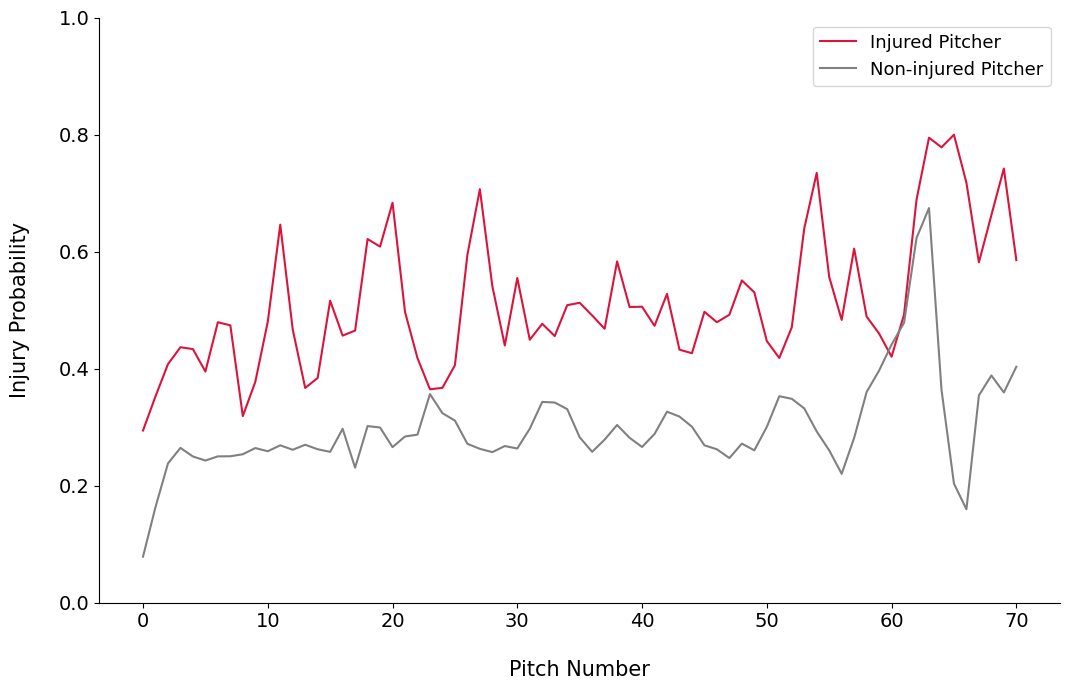

In [545]:
# plot injured and non-injured pitcher probabilities together
fig, axs = plt.subplots(1, 1, figsize=(12, 7), sharex='col')

axs.plot(pitch_level_probs['injured']['probs'].squeeze(), color='crimson', label='Injured Pitcher')
axs.plot(pitch_level_probs['noninjured']['probs'].squeeze(), color='gray', label='Non-injured Pitcher')

axs.set_ylim(0, 1)
axs.set_xlabel('\nPitch Number', fontsize=15)
axs.set_ylabel('Injury Probability\n', fontsize=15)
axs.legend(fontsize=13)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
plt.tight_layout(rect=[0.05, 0, 0.95, 1])
plt.show()

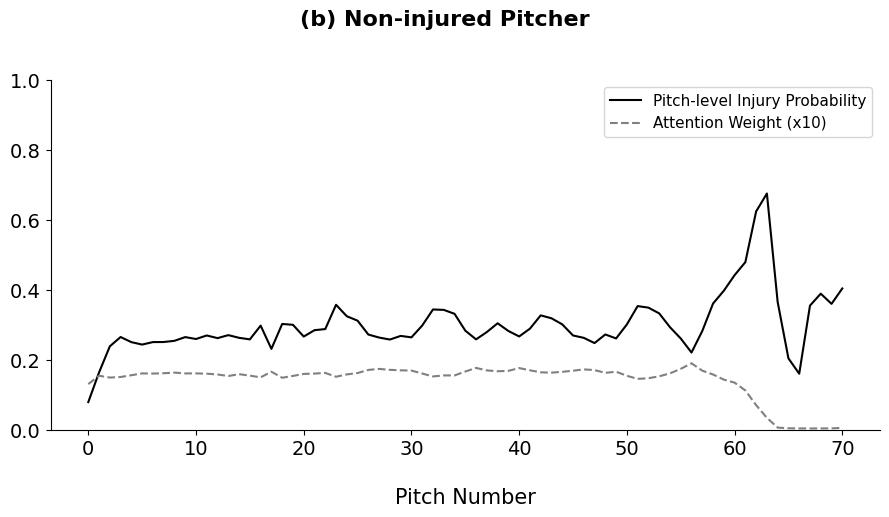

In [548]:
# non-injured pitcher
fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex='col')
axs.plot(pitch_level_probs['noninjured']['probs'].squeeze(), color='black', label='Pitch-level Injury Probability')
axs.plot(pitch_level_probs['noninjured']['attn'] * 10, color='gray', linestyle='--', label='Attention Weight (x10)')
axs.set_ylim(0, 1)
axs.set_xlabel('\nPitch Number', fontsize=15)
axs.set_ylabel('\n', fontsize=15)
axs.legend(fontsize=13)

# increase tick sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# hide upper and right spines
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

# add title
fig.suptitle('(b) Non-injured Pitcher', fontsize=16, fontweight='bold', y=1.025)
plt.legend(fontsize=11)
plt.tight_layout(rect=[0.05, 0, 0.95, 1])
plt.show()

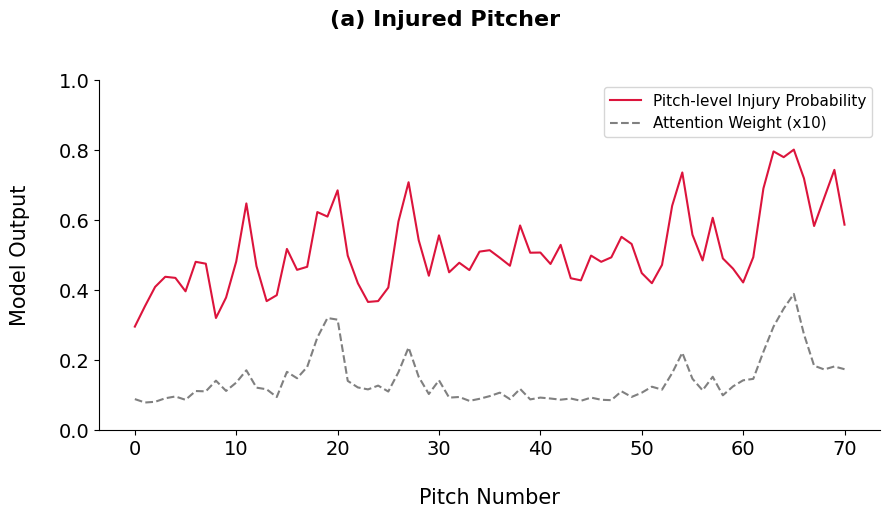

In [547]:
# Injured pitcher
fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex='col')

axs.plot(pitch_level_probs['injured']['probs'].squeeze(), color='crimson', label='Pitch-level Injury Probability')
axs.plot(pitch_level_probs['injured']['attn'] * 10, color='gray', linestyle='--', label='Attention Weight (x10)')
axs.set_ylim(0, 1)
axs.set_xlabel('\nPitch Number', fontsize=15)
axs.set_ylabel('Model Output\n', fontsize=15)
axs.legend(fontsize=13)

# increase tick sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# hide upper and right spines
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

# add title
fig.suptitle('(a) Injured Pitcher', fontsize=16, fontweight='bold', y=1.025)
plt.legend(fontsize=11)
plt.tight_layout(rect=[0.05, 0, 0.95, 1])
plt.show()

$\textit{Aggregate All Pitch-Level Probs}$

Intended to build on the above. Plot a smoothed curve of pitch-level probs (injured/non-injured) for aggregate comparison.

In [17]:
import matplotlib.pyplot as plt 

In [24]:
# iterate through all sequences, store probs
seq_probs = {
    'injured': [],
    'noninjured': []
}
for i in range(val_data['x'].shape[0]):
    with torch.no_grad():
        # get model output
        seq, _, _ = model_app(
            val_data['x'][i].unsqueeze(0).float(), 
            torch.Tensor([val_data['x'][i][val_data['mask'][i]].shape[0]]),
            val_data['mask'][i].unsqueeze(0).bool()
        )
        seq_masked = seq[0][val_data['mask'][i].bool()].squeeze().cpu().numpy()

        # create dataframe of pitch-level probs
            # --> normalize to 0-1 range
        seq_df = pd.DataFrame(seq_masked, index=range(1, len(seq_masked)+1), columns=['inj_prob'])
        seq_df.insert(
            0,
            'perc_seq',
            ((seq_df.index - seq_df.index.min()) / (seq_df.index.max() - seq_df.index.min())).round(3)
        )

        
        # add to storage
        if val_data['y_binary'][i].mean() == 1:
            seq_df['label'] = 1
            seq_probs['injured'].append(seq_df.iloc)
        else:
            seq_df['label'] = 0
            seq_probs['noninjured'].append(seq_df.iloc)

# concatenate all dataframes
seq_probs['injured'] = pd.concat(seq_probs['injured'], axis=0)
seq_probs['noninjured'] = pd.concat(seq_probs['noninjured'], axis=0)

In [25]:
# aggregate mean probabilities by percent of sequence
agg_inj = seq_probs['injured'].groupby('perc_seq')['inj_prob'].mean().reset_index()
agg_noninj = seq_probs['noninjured'].groupby('perc_seq').mean()['inj_prob'].reset_index()

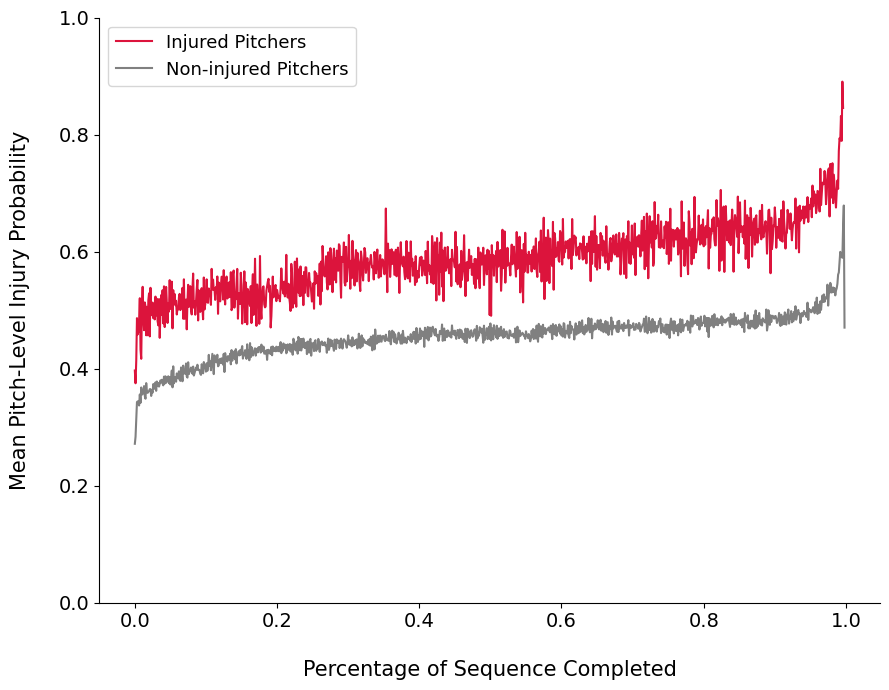

In [26]:
# plot aggregate probabilities together
fig, axs = plt.subplots(1, 1, figsize=(10, 7), sharex='col')
axs.plot(agg_inj['perc_seq'], agg_inj['inj_prob'], color='crimson', label='Injured Pitchers')
axs.plot(agg_noninj['perc_seq'], agg_noninj['inj_prob'], color='gray', label='Non-injured Pitchers')

# update y-limit
axs.set_ylim(0, 1)

# set labels
axs.set_xlabel('\nPercentage of Sequence Completed', fontsize=15)
axs.set_ylabel('Mean Pitch-Level Injury Probability\n', fontsize=15)
axs.legend(fontsize=13)

# increase tick sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# hide upper and right spines
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

plt.tight_layout(rect=[0.05, 0, 0.95, 1])
plt.show()

$\textbf{Post-hoc Analyses}$

In [70]:
from connections import AWS
from scipy.stats import ttest_ind

In [65]:
aws = AWS()
aws.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


$\textit{In-game vs. Bullpen Comps}$

In [ ]:
# post-hoc comparison: in-game vs. bullpen preds
in_game = aws.load_s3_object('epidemiology/ml/datasets/preds/model_application.csv')

# load bullpen data --> merge info, normalize
subject_info = aws.load_subject_info()
bullpen = aws.load_s3_object('biomechanics/ml/modeling_summary/model_preds.csv')
bullpen = bullpen.merge(subject_info, on='subject_id', how='left')
bullpen['pred_norm'] = bullpen['peak_pred_rf'] / (bullpen['height'] * bullpen['mass'] * 9.81)

In [83]:
# compare bullpen vs in-game normalized predictions
percent_diff = 100 * (in_game['pred_peak_evt_normalized'].mean() - bullpen['pred_norm'].mean()) / bullpen['pred_norm'].mean()
stat, pval = ttest_ind(bullpen['pred_norm'], in_game['pred_peak_evt_normalized'], equal_var=False)
print(f"T-statistic: {stat:.3f}, p-value: {pval:.3g} | Percent Difference: {percent_diff:.2f}%")

T-statistic: -11.039, p-value: 8.76e-28 | Percent Difference: 2.79%


$\textit{Close AWS Connection}$

In [85]:
# close AWS connection
aws.close()

[AWS]: Database connection closed.
[AWS]: SSH tunnel stopped.
